In [1]:
import pandas as pd
import os
import numpy as np
import datetime
import chardet
import time
from matplotlib import pyplot as plt
from collections import Counter
from itertools import combinations

In [2]:
soot_results = pd.read_csv('soot-results.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
loi = pd.read_csv('LOI.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

In [3]:
def get_loi(project, class_name,  method, merge_commit):

        filter_scenario = (loi['Project'] == str(project)) & (loi['Merge Commit'] == str(merge_commit)) & (loi['Class Name'] == str(class_name)) & (loi['Method or field declaration changed by the two merged branches'] == str(method))
        value_LOI = ""

        if filter_scenario.any():
            value_LOI = loi.loc[filter_scenario, 'Locally Observable Interference'].values[0]

        return value_LOI

In [4]:
info_LOI = ['project', 'class', 'method', 'merge commit']

list_values = soot_results.columns.tolist()
remove_columns = ['project', 'class', 'method', 'merge commit', 'Time']
analysis = [coluna for coluna in list_values if coluna not in remove_columns]



In [5]:
left_right_analysis = list(set([x.replace("left right ", "") for x in analysis if "left right " in x]))
analysis_name = list(set([x.replace("left right ", "").replace("right left ", "") for x in analysis]))


In [6]:
def get_name(list_name):
    for i in list_name:
        if "left right " in i:
            return (i.replace("left right ", ""))    
        elif "right left " not in i:
            return i
    return ""

def get_name_analysis(list_name):
    names = []
    for i in list_name:
        if (i in left_right_analysis):
            names.append("left right "+i)
            names.append("right left "+i)
        else:
            names.append(i)
    return names

def get_reverse_name(lists):
    names = []
    for elem_list in lists:
        aux_list = []
        for i in elem_list:
            if "left right" in i:
                aux_list.append(i.replace("left right ", ""))
            elif ("right left " not in i):
                aux_list.append(i)
        names.append(aux_list)
    return names


In [7]:
def calculate_matrix(columns):
    results = []
    for index, row in soot_results.iterrows():
        values = [row[column] for column in columns]
        actual_loi = get_loi(row['project'], row['class'], row['method'], row['merge commit'])
        or_value = any(value != 'false' for value in values)
        result = ""
        # print("OR:", or_value, "LOI:", actual_loi)
        if or_value == True and actual_loi == 'Yes':
            result = "TRUE POSITIVE"
        elif or_value == False and actual_loi == 'No':
            result = "TRUE NEGATIVE"
        elif or_value == False and actual_loi == 'Yes':
            result = "FALSE NEGATIVE"
        elif or_value == True and actual_loi == 'No':
            result = "FALSE POSITIVE"
        if actual_loi != "-":
            results.append(result)
    return results

In [8]:
def count_fp_fn(list_result):
    # Criar um contador dos elementos da lista
    element_count = Counter(list_result)

    result = []
    # Imprimir a contagem de elementos repetidos
    for element, count in element_count.items():
        if count > 1:
            result.append((str(element)+": "+str(count)))
    return result

In [9]:
#testando algoritmo de OU exclusivo genérico

# data_dict = {'PDG': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'CDe': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'CD': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'DFP-Inter': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'Confluence Inter': ['FALSE POSITIVE', 'FALSE POSITIVE'],
# 'DFP-Intra': ['TRUE POSITIVE', 'TRUE POSITIVE'],
# 'PDG-e': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'Confluence Intra': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'OA Inter': ['FALSE POSITIVE', 'TRUE POSITIVE']}

def check_equals_all(val, dict, pos):
    result = False
    for lista in dict.values():
        if (lista[pos] in val):
            result = True 
    return result        


def calculate_exclusive(data_dict, val):
    n = len(data_dict[next(iter(data_dict))])
    final_dict = {}
    for actual_key, actual_item in data_dict.items():
        final_dict[actual_key] = 0    
        data_dict_exclude = {chave: valor for chave, valor in data_dict.items() if chave != actual_key}
        cont = 0
        for i in range(n):
            all_equals_val = check_equals_all(val, data_dict_exclude, i)
            if val in actual_item[i] and not all_equals_val:
                cont = cont + 1
                print(actual_key)
        final_dict[actual_key] = cont
    return final_dict
        

Exclusive TP
PDG-e

Exclusive FP
DFP-Inter
DFP-Inter
Confluence Inter
Confluence Inter
PDG-e


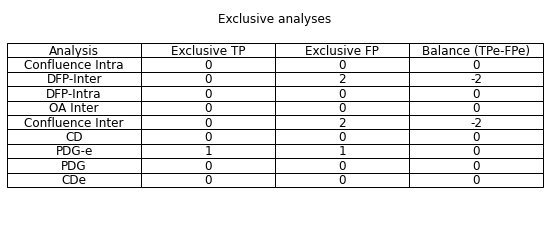

In [10]:
#Cálculo de TP e FP exclusivo para cada análise
analysis_exclusive = []
list_of_analysis = [[item] for item in analysis_name]

for i in list_of_analysis:
    analysis_exclusive.append(get_name_analysis(i))

data_dict = {}

for i in analysis_exclusive:
    data_dict[get_name(i)] = calculate_matrix(i) 

print("Exclusive TP")
res_tp = calculate_exclusive(data_dict, "TRUE POSITIVE")
# print(res_tp)


print("\nExclusive FP")
res_fp = calculate_exclusive(data_dict, "FALSE POSITIVE")
# print(res_fp)

data = {
    'Analysis': res_tp.keys(),
    'Exclusive TP': res_tp.values(),
    'Exclusive FP': res_fp.values()
}

dframe = pd.DataFrame(data)
dframe['Balance (TPe-FPe)'] = dframe['Exclusive TP'] - dframe['Exclusive FP']

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=dframe.values, colLabels=dframe.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.title("Exclusive analyses", y=0.9)
plt.savefig('exclusive_analysis.jpg', dpi=300, bbox_inches='tight', pad_inches=0.5)

